In [2]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleModels as nrn

In [4]:
params_pn = {'tau':20, 'r':100, 'vth':-40, 'v0':-65, 'vahp':-80, 'vmax':30, 'ev':-65, 'tahp':10}
params_pv = {'tau':5, 'r':100, 'vth':-50, 'v0':-65, 'vahp':-80, 'vmax':30, 'ev':-65, 'tahp':0}

# single model

In [112]:
nrn.set_times(tmax=500, dt=0.01)
seed = 102200
nrn.set_seed(seed)

## single cell

In [84]:
Iext = np.zeros(nrn._nitr)
t = nrn._times[1:]
Iext[(t > 100)&(t<400)] = 0.3

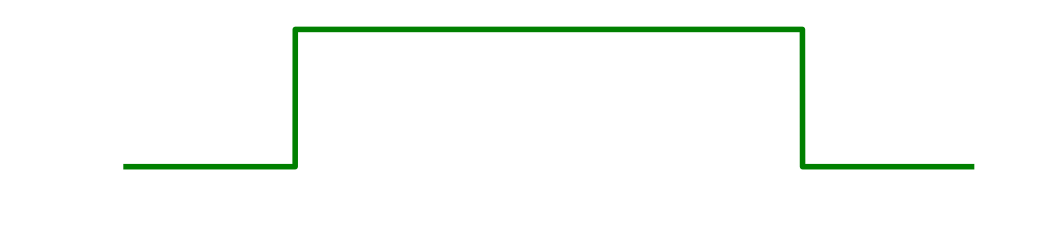

In [85]:
plt.figure(dpi=200, figsize=(6, 1))
plt.plot(nrn._times[1:], Iext,  'g', lw=2)
plt.axis('off')
plt.savefig('./figs/ext_current.png')
plt.show()

### PN cell

In [86]:
pn = nrn.CellNetwork(**params_pn, Iext=Iext, target_id=[[0]], syn=None, std=0.0)
pn.run()

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 53264.13it/s]


In [116]:
color_pn = np.array([192, 0, 0])/255

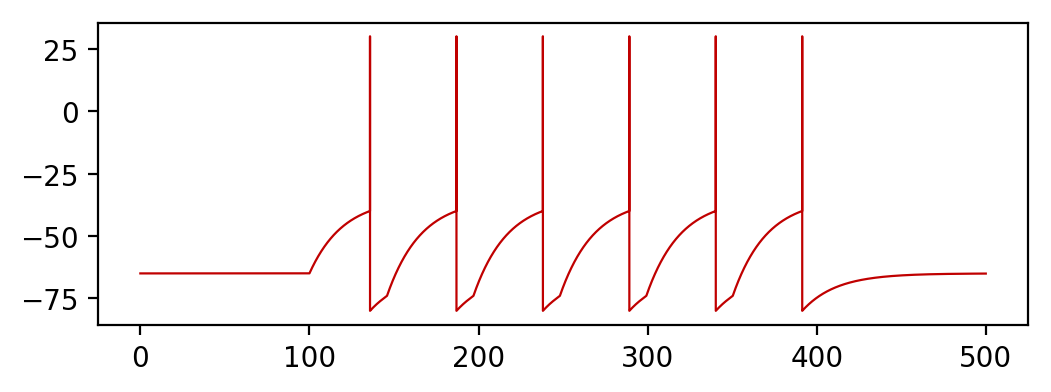

In [117]:
plt.figure(dpi=200, figsize=(6, 2))
plt.plot(nrn._times, pn.vcells[:, 0], c=color_pn, lw=0.8)
plt.axis()
plt.savefig('./figs/PN_cell.png')
plt.show()

### PV cell

In [88]:
pv = nrn.CellNetwork(**params_pv, Iext=Iext, target_id=[[0]], syn=None, std=0.0)
pv.run()

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 53642.58it/s]


In [115]:
color_pv = np.array([47, 85, 151])/255

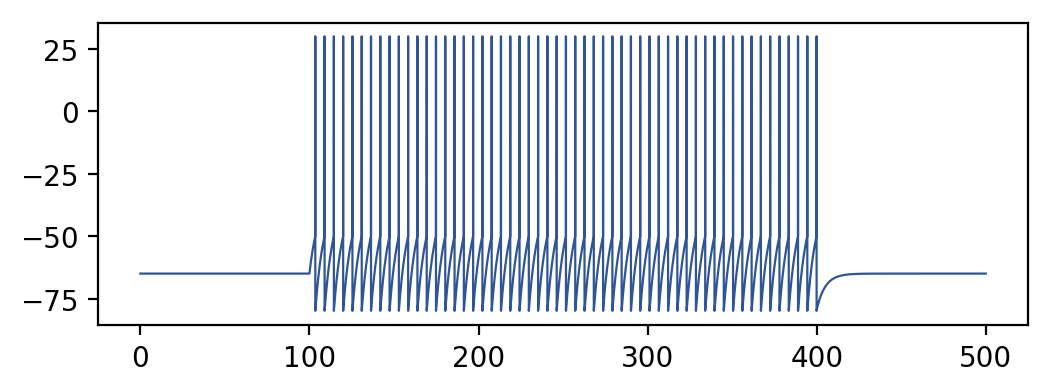

In [113]:
plt.figure(dpi=200, figsize=(6, 2))
plt.plot(nrn._times, pv.vcells[:, 0], c=color_pv, lw=0.8)
plt.axis()
plt.savefig('./figs/PV_cell.png')
plt.show()

## firing frequency

In [118]:
nrn.set_times(tmax=300, dt=0.01)

### pn

In [106]:
ii = np.ones(nrn._nitr)
i_amp_pn = np.linspace(0, 1, 50)

# vcells = np.zeros([len(i_amp), nrn._nitr+1])
frs_pn = np.zeros(len(i_amp_pn))

for i, amp in enumerate(i_amp_pn):
    pns = nrn.CellNetwork(**params_pn, Iext=ii*amp, target_id=[[0]], syn=None, std=0.)
    pns.run()
    
    if len(pns.spks[0]) > 2:
        tspks = np.array(pns.spks[0])
        frs_pn[i] = np.average(1e3 / (tspks[1:] - tspks[:-1]))
    elif len(pns.spks[0]) == 2:
        frs_pn[i] = 1e3 / (pns.spks[0][1] - pns.spks[0][0])

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:00<00:00, 51453.33it/s]


### pv

In [108]:
ii = np.ones(nrn._nitr)
i_amp_pv = np.linspace(0, 0.5, 50)

# vcells = np.zeros([len(i_amp), nrn._nitr+1])
frs_pv = np.zeros(len(i_amp_pv))

for i, amp in enumerate(i_amp_pv):
    pvs = nrn.CellNetwork(**params_pv, Iext=ii*amp, target_id=[[0]], syn=None, std=0.)
    pvs.run()
    
    if len(pvs.spks[0]) > 2:
        tspks = np.array(pvs.spks[0])
        frs_pv[i] = np.average(1e3 / (tspks[1:] - tspks[:-1]))
    elif len(pns.spks[0]) == 2:
        frs_pv[i] = 1e3 / (pvs.spks[0][1] - pvs.spks[0][0])

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:00<00:00, 52236.16it/s]


### figures

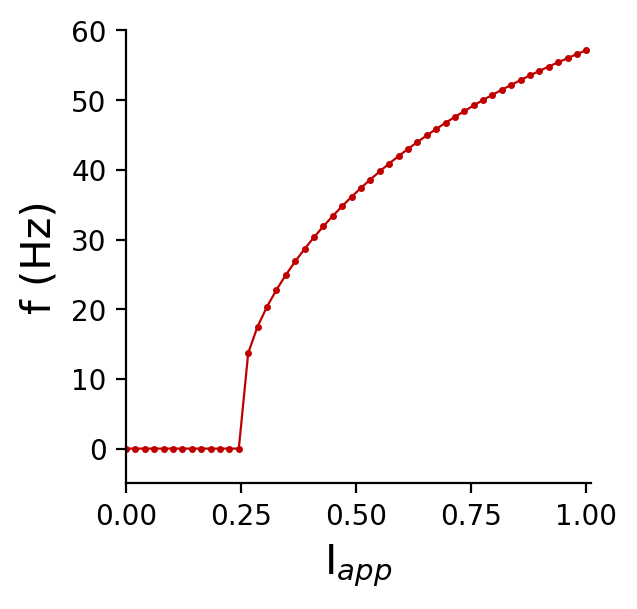

In [141]:
plt.figure(dpi=200, figsize=(3, 3))
plt.plot(i_amp_pn, frs_pn, '.-', c=color_pn, ms=3, lw=0.8)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xlabel(r'I$_{app}$', fontsize=15)
plt.ylabel('f (Hz)', fontsize=15)

plt.xlim([0, i_amp_pn[-1]+0.01])
plt.ylim([-5, 60])

plt.show()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


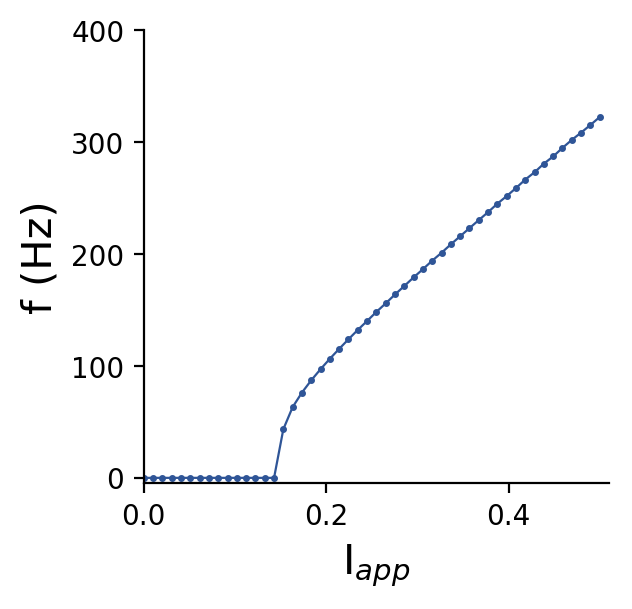

In [145]:
plt.figure(dpi=200, figsize=(3, 3))
plt.plot(i_amp_pv, frs_pv, '.-', c=color_pv, ms=3, lw=0.8)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xlabel(r'I$_{app}$', fontsize=15)
plt.ylabel('f (Hz)', fontsize=15, fontname='Arial')

plt.xlim([0, i_amp_pv[-1]+0.01])
plt.ylim([-5, 400])

plt.show()

# one time stimulation

# w pfc

In [155]:
import os

fdir = './data/w_pfc_x/'
fnames = os.listdir(fdir)
nrn.set_times(tmax=250, dt=0.01)

In [156]:
from tqdm import tqdm
import pickle

In [157]:
def getFFT(x, idt):
    fx = np.fft.fft(x[idt]) / sum(idt)
    f = np.fft.fftfreq(sum(idt), nrn._dt/(1e3))
    fx = abs(fx[:int(sum(idt)//2)])
    f = f[:int(sum(idt)//2)]
    return f, fx

def find_peak(x, f, idf=None):
    if idf is None:
        idf = np.ones(len(x), dtype=bool)
    ind = np.where(x == max(x[idf]))[0][0]
    return f[ind]

In [158]:
fpeaks = np.zeros([10, 10, 10])

idt = (nrn._times>50) & (nrn._times<250)
fx_all = []
v_all = []
for i in range(10):
    v_all.append([])
    fx_all.append([])
    for j in tqdm(range(10)):
        target_names = [f for f in fnames if 'ntk_calc_vals_%d%d.pickle'%(i, j) in f]
        for k, fname in enumerate(target_names):
            with open(fdir+fname, 'rb') as f:
                v = pickle.load(f)
            v_all[-1].append(v)

            vsum = np.average(v, axis=1)
            
            f, fx = getFFT(vsum, idt)
            
            
            idf = f > 1
            f = f[idf]
            fx = fx[idf]
            
            fx_all[-1].append(fx)
            fpeaks[i, j, k] = find_peak(fx, f)
            

100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


In [160]:
np.save('./fx_all.npy', fx_all)